In [1]:
#Libraries imports
import pandas as pd
import requests
from bs4 import BeautifulSoup
import folium
import json
import sys
from matplotlib import animation as animation, pyplot as plt
import geojson
import datapackage 
import datetime
import numpy as np
import bar_chart_race as bcr
import seaborn as sns
import sklearn


c:\Users\theoi\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [2]:
# Request actual top 200 ATP male players en espn site
page = requests.get("https://www.espn.com/tennis/rankings")

In [3]:
# Scrapping data using BeautifulSoup library
soup = BeautifulSoup(page.content, 'html.parser')

# Look for the table of interest
print('Classes of each table:')
for table in soup.find_all('table'):
    print(table.get('class'))


Classes of each table:
['Table', 'Table--align-right']


In [4]:
# Extract data from the table
tab = soup.find("table",{"class":"Table--align-right"})

# Isolate names of the countries corresponding to the flag
nations = soup.find_all(class_ = "Image Logo Logo__sm",attrs ={'title'})

In [5]:
# Creating the dataframe
df = pd.DataFrame(columns=['Rankings','Player', 'Country', 'Age'])

# and extract corresponding data
for row in tab.tbody.find_all('tr'):    
    # Find all data for each column   
    # Find all data for each column
    columns = row.find_all('td')
    
    if(columns != []):
        rankings = columns[0].text.strip()
        player = columns[2].text.strip('&0.')
        country = columns[2].find('Image Logo Logo__sm')
        age = columns[4].text.strip('&0.')
        

        df = df.append({'Rankings': rankings,  'Player': player, 'Age': age,'Country': country}, ignore_index=True)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_7076\2068788865.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Rankings': rankings,  'Player': player, 'Age': age,'Country': country}, ignore_index=True)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_7076\2068788865.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Rankings': rankings,  'Player': player, 'Age': age,'Country': country}, ignore_index=True)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_7076\2068788865.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Rankings': rankings,  'Player': player, 'Age': age,'Country': country}, ignore_index=True)
C:\Users\Public\Docume

In [6]:
# Assign nationality to player based on the flag
for i in range(150):
    df['Country'][i] = nations[i]['title']

df.reset_index(drop=True,inplace=True)

In [7]:
# Count number of top 200 players by country
bestcountries = df.groupby('Country').count()['Age']
bestcountries = pd.DataFrame(bestcountries)
bestcountries['index'] = bestcountries.index
bestcountries = bestcountries.drop('index',axis = 1)
bestcountries["Name"] = bestcountries.index

In [8]:
# Setting up the world countries data URL
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
country_shapes = f'{url}/world-countries.json'

In [9]:
# Extracting A3 and A2 country names
codes = pd.read_excel('../data/codes.xlsx')

bestcountries = bestcountries[['Name', 'Age']]
country = pd.read_csv('../data/data_cod.csv')
country = country.merge(bestcountries,how='left', left_on='Name', right_on='Name')
country.fillna(0,inplace = True)

results = codes.merge(country,right_on='Code',left_on='Code-2' )
results = results[['Country','Age']]
results[['Age']] = results[['Age']].astype(int)

In [10]:
#create object, world map randomn location with minimal zoom
m = folium.Map(location=[45.5236, -22.6750], zoom_start = 2)


folium.Choropleth(
    #coordinates of countries
    geo_data=country_shapes,
    name='choropleth',
    #players data and nationality
    data=results,
    columns=["Country", "Age"],
    #mapping nationality of players with country names
    key_on='feature.properties.name',
    fill_color="YlGn",
    nan_fill_color='white',
    fill_opacity=0.7,
    line_opacity=.1,
    legend_name="Top 200 Players repartition",
).add_to(m)

#add the overlay on our world map
folium.LayerControl().add_to(m)

#save map as html object
m.save("../out/Top200_map.html")

m

In [11]:
#Load data matches 1968 - 2019
atp2 = pd.read_csv('../data/ATP2.csv',encoding='latin-1')

In [12]:
# Cleaning and processing 
atp2 = atp2[['loser_name','winner_name','surface','best_of','loser_age','winner_age','tourney_date','round','winner_rank','loser_rank','winner_rank_points','loser_rank_points']]

# Focus on the matches of 2000 
atp2 = atp2[atp2.tourney_date >= 20000103]

atp2['Lage'] = atp2['loser_age'].apply(np.floor)
atp2['Wage'] = atp2['winner_age'].apply(np.floor)

atp2['Winner'] = atp2['winner_name'].str.split().str[-1]
atp2['Loser'] = atp2['loser_name'].str.split().str[-1]
atp2['Date'] = atp2['tourney_date']

atp2.drop(labels =['winner_name','loser_name','tourney_date','loser_age','winner_age'], axis = 1,inplace = True)


In [13]:
atp2 = atp2[(atp2['round'] != 'RR') & (atp2['round'] != 'BR')]

atp2['round'] = atp2['round'].astype('category')
atp2['round'].replace({"R128": "128", "R64": "64", "R32": "32","R16":"16", "R8" : "8", "QF" : "4", "SF": "2", "F":"1"}, inplace=True) 

atp2['LRank'] = atp2['loser_rank']
atp2['LPoints'] = atp2['loser_rank_points']
atp2['WRank'] = atp2['winner_rank']
atp2['WPoints'] = atp2['winner_rank_points']

atp = atp2[['Date','surface','round','best_of','Winner','Loser','WRank','LRank','Wage','Lage','WPoints','LPoints']]

In [14]:
atp2019 = pd.read_csv('../data/atp_matches_2019.csv')
atp2020 = pd.read_csv('../data/atp_matches_2020.csv')
atp2021 = pd.read_csv('../data/atp_matches_2021.csv')
atp2022 = pd.read_csv('../data/atp_matches_2022.csv')

atp1922 = pd.concat([atp2019,atp2020,atp2021,atp2022])

atp1922 = atp1922 [(atp1922 ['round'] != 'RR') & (atp1922 ['round'] != 'BR')]

atp1922 ['round'] = atp2019 ['round'].astype('category')
atp1922 ['round'].replace({"R128": "128", "R64": "64", "R32": "32","R16":"16", "R8" : "8", "QF" : "4", "SF": "2", "F":"1"}, inplace=True) 

atp1922['Lage'] = atp1922['loser_age'].apply(np.floor)
atp1922['Wage'] = atp1922['winner_age'].apply(np.floor)

atp1922['Winner'] = atp1922['winner_name'].str.split().str[-1]
atp1922['Loser'] = atp1922['loser_name'].str.split().str[-1]
atp1922['Date'] = atp1922['tourney_date']


atp1922 ['LRank'] = atp1922 ['loser_rank']
atp1922 ['LPoints'] = atp1922 ['loser_rank_points']
atp1922 ['WRank'] = atp1922 ['winner_rank']
atp1922 ['WPoints'] = atp1922 ['winner_rank_points']

atp1922 = atp1922[['Date','surface','round','best_of','Winner','Loser','WRank','LRank','Wage','Lage','WPoints','LPoints']] 

In [15]:
atp = pd.concat([atp,atp1922])

In [16]:
## WHO WON THE MOST TITLE BETWEEN 2000 and 2019

# Focus on the final
final = atp.loc[atp['round']== '1']

# Extract the 10 players with the most final victories
top_win = final['Winner'].value_counts()[:10].index.tolist()
final = final[final['Winner'].isin(top_win)]

final['count'] = final.groupby(['Winner']).cumcount().add(1)
final = final[['Winner','Date','count']]

In [17]:
count_hewitt = final.loc[final['Winner']=='Hewitt'].set_index('Date')
count_federer = final.loc[final['Winner']=='Federer'].set_index('Date')
count_roddick = final.loc[final['Winner']=='Roddick'].set_index('Date')
count_ferrer = final.loc[final['Winner']=='Ferrer'].set_index('Date')
count_davydenko = final.loc[final['Winner']=='Davydenko'].set_index('Date')
count_nadal = final.loc[final['Winner']=='Nadal'].set_index('Date')
count_murray = final.loc[final['Winner']=='Murray'].set_index('Date')
count_djokovic = final.loc[final['Winner']=='Djokovic'].set_index('Date')
count_potro = final.loc[final['Winner']=='Potro'].set_index('Date')
count_tsonga = final.loc[final['Winner']=='Tsonga'].set_index('Date')



In [18]:
toppp = pd.DataFrame(columns=top_win,index = final['Date'])
toppp.fillna(0,inplace=True)


In [19]:
toppp

,Federer,Nadal,Djokovic,Murray,Roddick,Hewitt,Ferrer,Potro,Davydenko,Tsonga
Date,,,,,,,,,,
20000103,0,0,0,0,0,0,0,0,0,0
20000110,0,0,0,0,0,0,0,0,0,0
20000306,0,0,0,0,0,0,0,0,0,0
20000612,0,0,0,0,0,0,0,0,0,0
20010108,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
20200224,0,0,0,0,0,0,0,0,0,0
20210419,0,0,0,0,0,0,0,0,0,0
20210628,0,0,0,0,0,0,0,0,0,0


In [20]:
toppp = toppp.combine_first(count_hewitt)
toppp['Hewitt'] = toppp['count']
toppp['count'].values[:] = None

toppp = toppp.combine_first(count_tsonga)
toppp['Tsonga'] = toppp['count']
toppp['count'].values[:] = None

toppp = toppp.combine_first(count_davydenko)
toppp['Davydenko'] = toppp['count']
toppp['count'].values[:] = None

toppp = toppp.combine_first(count_ferrer)
toppp['Ferrer'] = toppp['count']
toppp['count'].values[:] = None

toppp = toppp.combine_first(count_djokovic)
toppp['Djokovic'] = toppp['count']
toppp['count'].values[:] = None

toppp = toppp.combine_first(count_nadal)
toppp['Nadal'] = toppp['count']
toppp['count'].values[:] = None

toppp = toppp.combine_first(count_murray)
toppp['Murray'] = toppp['count']
toppp['count'].values[:] = None

toppp = toppp.combine_first(count_federer)
toppp['Federer'] = toppp['count']
toppp['count'].values[:] = None

toppp = toppp.combine_first(count_potro)
toppp['Potro'] = toppp['count']
toppp['count'].values[:] = None

toppp = toppp.combine_first(count_roddick)
toppp['Roddick'] = toppp['count']
toppp['count'].values[:] = None
toppp.fillna(0,inplace = True)


toppp.replace(to_replace=0.0, method='ffill').values

array([[0.0, 0.0, 0.0, ..., 0.0, 'Hewitt', 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 'Hewitt', 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 'Hewitt', 0.0],
       ...,
       [21.0, 82.0, 104.0, ..., 19.0, 'Murray', 0.0],
       [21.0, 83.0, 104.0, ..., 19.0, 'Djokovic', 0.0],
       [21.0, 83.0, 104.0, ..., 19.0, 'Murray', 0.0]], dtype=object)

In [21]:
toppp = toppp.replace(0.0, method='ffill')
toppp['nouveau'] = toppp.index
toppp['nouveau'] = pd.to_datetime(toppp['nouveau'] , format='%Y%m%d').dt.strftime('%Y-%m-%d')

toppp = toppp.set_index(['nouveau'])
toppp = toppp.drop(['count','Winner'],axis = 1)

In [22]:
plt.rcParams['animation.ffmpeg_path'] = r'C:\Users\theoi\anaconda3\Library\bin\ffmpeg.exe'

bcr.bar_chart_race(
    df = toppp,
    filename="video.mp4",
    dpi = 144,
    steps_per_period = 20,
    period_length = 100
)

c:\Users\theoi\AppData\Local\Programs\Python\Python310\lib\site-packages\bar_chart_race\_make_chart.py:286: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.df_values.columns)
c:\Users\theoi\AppData\Local\Programs\Python\Python310\lib\site-packages\bar_chart_race\_make_chart.py:287: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))


KeyboardInterrupt: 

In [23]:
surface = atp.groupby(['surface','Winner'])['Winner']\
             .count()\
             .reset_index(name='count') \
             .sort_values(['count'], ascending=False) 
        


In [24]:
surface  = atp.groupby(['surface','Winner'])['Winner']\
             .count()\
             .reset_index(name='count') \
             .sort_values(['count'], ascending=False) 

c:\Users\theoi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


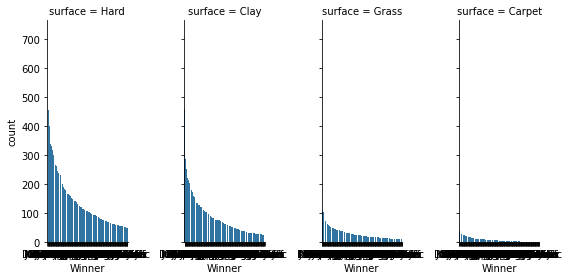

In [25]:
g = sns.FacetGrid(surface, col="surface", height=4, aspect=.5)
g.map(sns.barplot, "Winner", "count")

In [56]:
atp = atp.dropna()


In [57]:
atp.isna().sum()

Date       0
surface    0
round      0
best_of    0
Winner     0
Loser      0
WRank      0
LRank      0
Wage       0
Lage       0
WPoints    0
LPoints    0
dtype: int64

<AxesSubplot:>

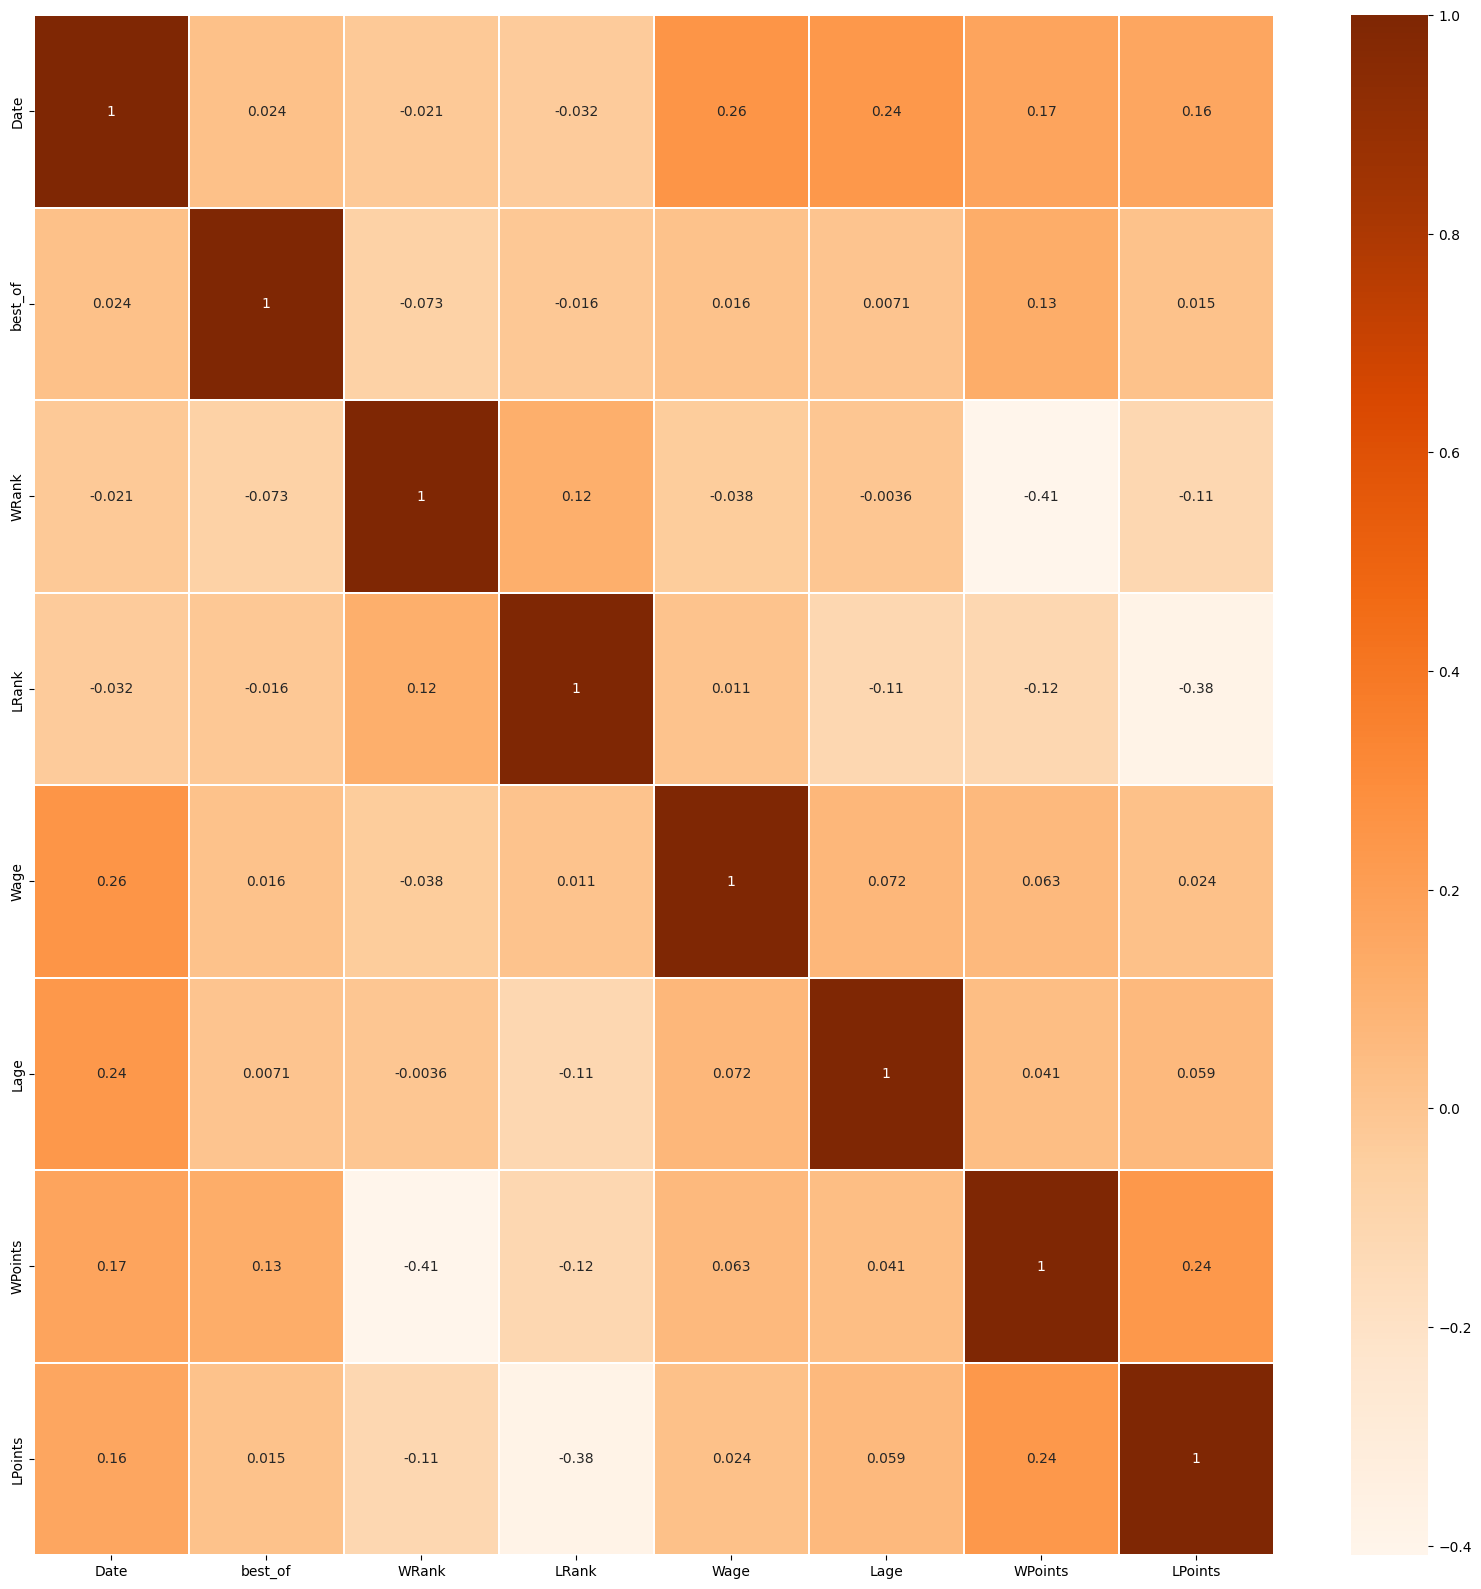

In [58]:
features = atp
correlation_matrix = features.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot= True, linewidth=0.1, cmap= 'Oranges')

In [59]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
players = pd.DataFrame(features['Winner'].append(features['Loser']))
players.columns = ['Name']

players = players.drop_duplicates()


players['player_id'] = lb_make.fit_transform(players['Name'])



C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_7076\2816432209.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  players = pd.DataFrame(features['Winner'].append(features['Loser']))


In [60]:
players['Winner'] = players['Name']
players['Loser'] = players['Name']
players['Winner_id'] = players['player_id']
players['Loser_id'] = players['player_id']

players.drop(columns=['Name','player_id'], inplace = True)

winner = players[['Winner','Winner_id']]
loser = players[['Loser','Loser_id']]


In [61]:
features = pd.merge(features,winner,on = "Winner", how = 'left')


In [62]:
features = pd.merge(features,loser,on = "Loser", how = 'left')

In [63]:
features.drop(columns=['Winner','Loser'],inplace = True)
features.head()

,Date,surface,round,best_of,WRank,LRank,Wage,Lage,WPoints,LPoints,Winner_id,Loser_id
0,20000103,Hard,32,3,4.0,56.0,25.0,22.0,1850.0,490.0,317,220
1,20000103,Hard,32,3,64.0,91.0,18.0,24.0,515.0,404.0,338,579
2,20000103,Hard,32,3,58.0,105.0,22.0,28.0,544.0,243.0,380,50
3,20000103,Hard,32,3,27.0,54.0,21.0,23.0,928.0,602.0,437,507
4,20000103,Hard,32,3,15.0,154.0,23.0,25.0,1244.0,219.0,844,290


In [64]:
features = features[features['round'] != 'RR']

In [65]:
features['round'].unique()

array(['32', '16', '4', '2', '1', '128', '64'], dtype=object)

In [66]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
features["surface"] = ord_enc.fit_transform(features[["surface"]])



In [67]:
features['surface'].unique()
features['Round'] = features['round'].astype(int)

In [ ]:
features.columns

Index(['Date', 'surface', 'round', 'best_of', 'second_rank', 'first_rank',
       'second_age', 'first_age', 'second_rank_points', 'first_rank_points',
       'second_id', 'first_id'],
      dtype='object')

: 

In [68]:
features = features.rename(columns={"Lage": "first_age", 
                        "Loser_id": "first_id", 
                        "LRank": "first_rank", 
                        "LPoints": "first_rank_points",
                        "Lage": "first_age",
                        "Wage": "second_age", 
                        "Winner_id": "second_id", 
                        "WRank": "second_rank", 
                        "WPoints": "second_rank_points"
                       },)

In [69]:
copy2 = features.copy()

copy2[[ 'first_age','first_id','first_rank',
            'second_age','second_id','second_rank']]\
=copy2[['second_age','second_id','second_rank',
             'first_age','first_id','first_rank']]

In [70]:
## Construct label feature
winner_player2 = np.zeros(features.shape[0]) # second player wins so label=0
features['label'] = winner_player2


winner_player1 = np.ones(copy2.shape[0]) # first player wins so label=1
copy2['label'] = winner_player1 

df = pd.concat([features,copy2])

In [71]:
df['round'] = df['round'].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121184 entries, 0 to 60592
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Date                121184 non-null  int64  
 1   surface             121184 non-null  float64
 2   round               121184 non-null  int32  
 3   best_of             121184 non-null  int64  
 4   second_rank         121184 non-null  float64
 5   first_rank          121184 non-null  float64
 6   second_age          121184 non-null  float64
 7   first_age           121184 non-null  float64
 8   second_rank_points  121184 non-null  float64
 9   first_rank_points   121184 non-null  float64
 10  second_id           121184 non-null  int32  
 11  first_id            121184 non-null  int32  
 12  Round               121184 non-null  int32  
 13  label               121184 non-null  float64
dtypes: float64(8), int32(4), int64(2)
memory usage: 12.0 MB


In [72]:
y = df['label']
df_X = df.drop(columns='label')

In [73]:
df.isnull().sum()/len(df)*100

Date                  0.0
surface               0.0
round                 0.0
best_of               0.0
second_rank           0.0
first_rank            0.0
second_age            0.0
first_age             0.0
second_rank_points    0.0
first_rank_points     0.0
second_id             0.0
first_id              0.0
Round                 0.0
label                 0.0
dtype: float64

In [47]:
df.isnull().sum().sum()

720

In [74]:
from sklearn.model_selection import train_test_split
from sklearn import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [75]:
# split data : 80% for train and 20% for test.
X_train, X_test, y_train, y_test = train_test_split(df_X, y, test_size=0.1)

In [76]:
X_train.isna().sum()

Date                  0
surface               0
round                 0
best_of               0
second_rank           0
first_rank            0
second_age            0
first_age             0
second_rank_points    0
first_rank_points     0
second_id             0
first_id              0
Round                 0
dtype: int64

In [77]:
#Call the classifier
RF_classifier = RandomForestClassifier(n_estimators=100)
#fit the data
RF_classifier.fit(X_train, y_train)
#predict 
RF_predictions = RF_classifier.predict(X_test)

In [79]:
print('Confusion matrix')
print(confusion_matrix(y_test,RF_predictions))
print('Classification report')
print(classification_report(y_test,RF_predictions))
print('Accuracy= ', accuracy_score(y_test, RF_predictions))

Confusion matrix
[[5762  157]
 [ 179 6021]]
Classification report
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      5919
         1.0       0.97      0.97      0.97      6200

    accuracy                           0.97     12119
   macro avg       0.97      0.97      0.97     12119
weighted avg       0.97      0.97      0.97     12119

Accuracy=  0.9722749401765822


In [ ]:
labels

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
46647    NaN
46648    NaN
46649    NaN
46650    NaN
46651    NaN
Name: Winner, Length: 46339, dtype: float64

: 

: 

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

: 

: 

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

ValueError: could not convert string to float: 'NR'

: 

: 

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

: 

: 